In [1]:
import sys
import feelpp
import feelpp.toolboxes.core as tb
from feelpp.toolboxes.cfpdes import *
import pandas as pd
import matplotlib

sys.argv = ["feelpp_cfpdes_poisson"]
e = feelpp.Environment(sys.argv,
                        opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                        config=feelpp.globalRepository("cfpdes-poisson-homogeneous-dirichlet"))


AttributeError: module 'feelpp' has no attribute 'Environment'

In [ ]:
def generateGeometry(filename,dim=2,hsize=0.1):
    """create gmsh mesh

    Args:
        filename (str): name of the file
        dim (int): dimension of the mesh
        hsize (float): mesh size
    """
    geo="""SetFactory("OpenCASCADE");
    h={};
    dim={};
    """.format(hsize,dim)
    if dim==2 :
        geo+="""
        Rectangle(1) = {0, 0, 0, 1, 1, 0};
        Characteristic Length{ PointsOf{ Surface{1}; } } = h;
        Physical Curve("Gamma_D") = {1,2,3,4};
        Physical Surface("Omega") = {1};
        """
    elif dim==3 :
        geo+="""
        Box(1) = {0, 0, 0, 1, 1, 1};
        Characteristic Length{ PointsOf{ Volume{1}; } } = h;
        Physical Surface("Gamma_D") = {1,2,3,4,5,6};
        Physical Volume("Omega") = {1};
        """
    with open(filename, 'w') as f:
        # Write the string to the file
        f.write(geo)

def getMesh(filename,hsize=0.05,dim=2,verbose=False):
    """create mesh

    Args:
        filename (str): name of the file
        hsize (float): mesh size
        dim (int): dimension of the mesh
        verbose (bool): verbose mode
    """
    import os
    for ext in [".msh",".geo"]:
        f=os.path.splitext(filename)[0]+ext
        # print(f)
        if os.path.exists(f):
            os.remove(f)
    if verbose:
        print(f"generate mesh {filename} with hsize={hsize} and dimension={dim}")
    generateGeometry(filename=filename,dim=dim,hsize=hsize)
    mesh = feelpp.load(feelpp.mesh(dim=dim,realdim=dim), filename, hsize)
    return mesh

# generate 2D abd 3D meshes
for dim in [2,3]:
    mesh = getMesh(f"omega-{dim}d.geo",hsize=0.1,dim=dim,verbose=True)


generate mesh omega-2d.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-2d.geo"
[loadMesh] Use default geo desc: /home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-2d.geo 0.1 
generate mesh omega-3d.geo with hsize=0.1 and dimension=3
[loadMesh] Loading mesh in format geo+msh: "/home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-3d.geo"
[loadMesh] Use default geo desc: /home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-3d.geo 0.1 


In [ ]:
def laplacian(hsize, json, dim=2,verbose=False):
    if verbose:
        print(f"Solving the laplacian problem for hsize = {hsize}...")
    laplacian = cfpdes(dim=dim, keyword=f"cfpdes-{dim}d")
    laplacian.setMesh(getMesh(f"omega-{dim}.geo",hsize=hsize,dim=dim,verbose=verbose))
    laplacian.setModelProperties(json)
    laplacian.init(buildModelAlgebraicFactory=True)
    laplacian.printAndSaveInfo()
    laplacian.solve()
    laplacian.exportResults()
    measures = laplacian.postProcessMeasures().values()

    return measures

laplacian_json = lambda order,dim=2,name="u":  {
    "Name": "Laplacian",
    "ShortName": "Laplacian",
    "Models":
    {
        f"cfpdes-{dim}d":
        {
            "equations":"laplace"
        },
        "laplace":{
            "setup":{
                "unknown":{
                    "basis":f"Pch{order}",
                    "name":f"{name}",
                    "symbol":"u"
                },
                "coefficients":{
                    "c":"1",

                    "f":"8*pi*pi*sin(2*pi*x)*sin(2*pi*y):x:y" if dim==2 else "12*pi*pi*sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z):x:y:z"
                }
            }
        }
    },
    "Materials":
    {
        "Omega":
        {
            "markers":["Omega"]
        }
    },
    "BoundaryConditions":
    {
        "laplace":
        {
            "Dirichlet":
            {
                "g":
                {
                    "markers":["Gamma_D"],
                    "expr":"0"
                }
            }
        }
    },
    "PostProcess":
    {
        f"cfpdes-{dim}d":
        {
            "Exports":
            {
                "fields":["all"],
                "expr":{
                    "u_exact":"sin(2*pi*x)*sin(2*pi*y):x:y" if dim==2 else "sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z):x:y:z",
                    "grad_u_exact": "{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}:x:y" if dim==2 else "{2*pi*cos(2*pi*x)*sin(2*pi*y)*sin(2*pi*z),2*pi*sin(2*pi*x)*cos(2*pi*y)*sin(2*pi*z),2*pi*sin(2*pi*x)*sin(2*pi*y)*cos(2*pi*z)}:x:y:z"
                }
            },
            "Measures" :
            {
              "Norm" :
              {
                  "laplace" :
                  {
                     "type":["L2-error", "H1-error"],
                     "field":f"laplace.{name}",
                     "solution":"sin(2*pi*x)*sin(2*pi*y):x:y" if dim==2 else "sin(2*pi*x)*sin(2*pi*y)*sin(2*pi*z):x:y:z",
                     "grad_solution":"{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}:x:y" if dim==2 else "{2*pi*cos(2*pi*x)*sin(2*pi*y)*sin(2*pi*z),2*pi*sin(2*pi*x)*cos(2*pi*y)*sin(2*pi*z),2*pi*sin(2*pi*x)*sin(2*pi*y)*cos(2*pi*z)}:x:y:z",
                     "markers":"Omega",
                     "quad":6
                 }
              },
                "Statistics":
                {
                    "mystatA":
                    {
                        "type":["min","max","mean","integrate"],
                        "field":f"laplace.{name}"
                    }
                }
            }
        }
    }
}
# simulate the laplacian problem for 2D and 3D
for dim in [2,3]:
    with open(f'laplacian-{dim}d.json', 'w') as f:
        # Write the string to the file
        import json
        f.write(json.dumps(laplacian_json(dim=dim,order=1),indent=1))
        # execute the laplacian problem using P1 basis on a mesh of the unit square  of size 0.1
        print('lap  =', laplacian(hsize=0.1,json=laplacian_json(order=1,dim=dim), dim=dim,verbose=True))
# execute the laplacian problem using P2 basis on a mesh of the unit square of size 0.1
#laplacian(hsize=0.025,json=laplacian_json(dim=2,order=2),dim=2,verbose=True)


Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-2.geo 0.1 
+-----------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d - Use Case Study                                                                             |
+-----------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                     |
| | Environment                                                                             |                     |
| +----------------------------------------------------------------------------

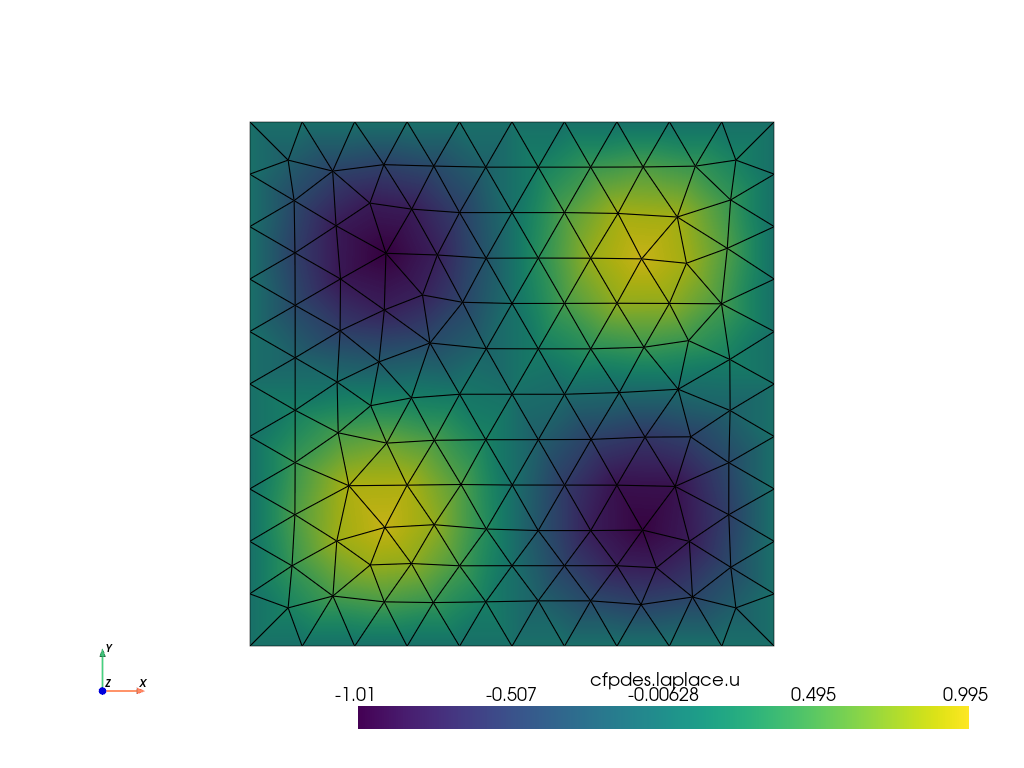

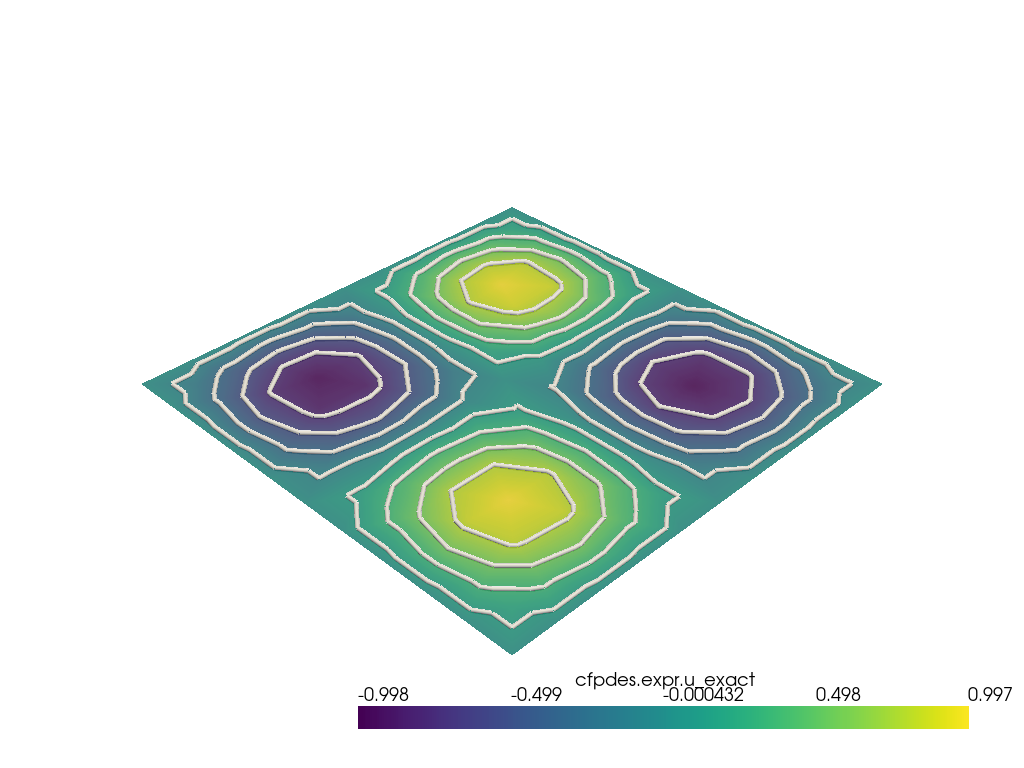

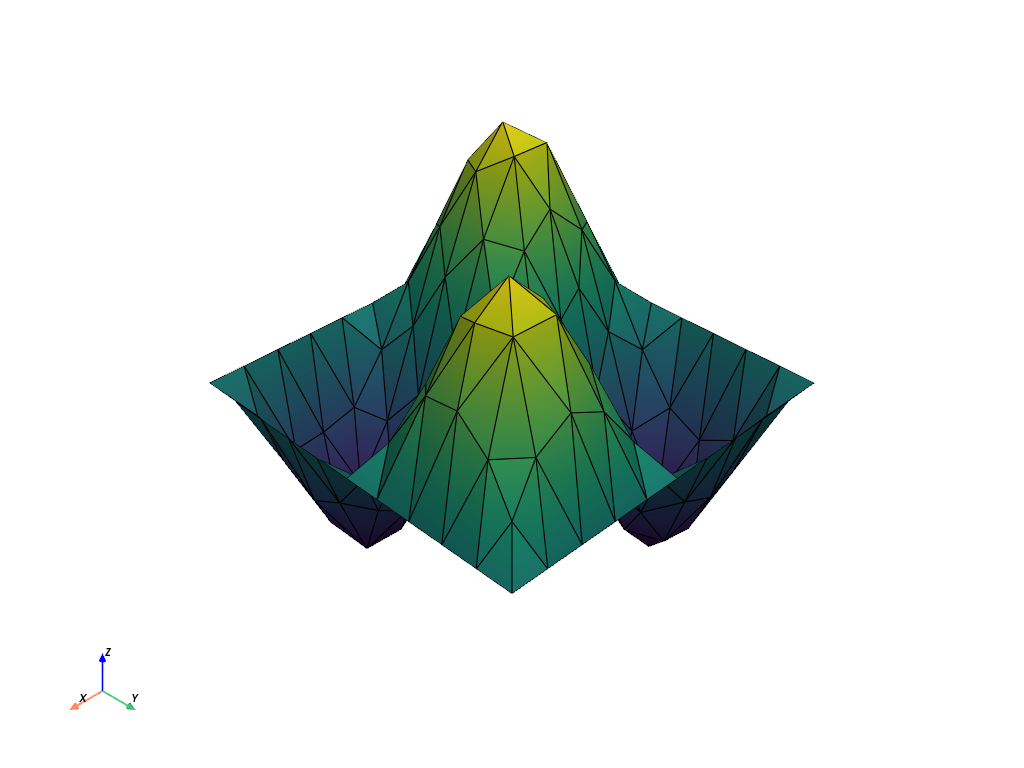

In [ ]:

from xvfbwrapper import Xvfb
vdisplay = Xvfb()
vdisplay.start()

import pyvista as pv
import os

pv.set_jupyter_backend('static')
def pv_get_mesh(mesh_path):
    reader = pv.get_reader(mesh_path)
    mesh = reader.read()
    return mesh

def pv_plot(mesh, field, clim=None, cmap='viridis', cpos='xy', show_scalar_bar=True, show_edges=True):
    mesh.plot(scalars=field, clim=clim, cmap=cmap, cpos=cpos, show_scalar_bar=show_scalar_bar, show_edges=show_edges)

def myplots(dim=2, field="cfpdes.laplace.u", factor=1, cmap='viridis'):
    mesh = pv_get_mesh(f"cfpdes-{dim}d.exports/Export.case")
    pv_plot(mesh, field)
    pl = pv.Plotter()
    contours = mesh[0].contour()
    pl.add_mesh(mesh[0], opacity=0.85)
    pl.add_mesh(contours, color="white", line_width=5, render_lines_as_tubes=True)
    pl.show()
    if dim == 2:
        warped = mesh[0].warp_by_scalar(field, factor=factor)
        warped.plot(cmap=cmap, show_scalar_bar=False, show_edges=True)
    else:
        slices = mesh.slice_orthogonal(x=0.2,y=0.4,z=.6)
        slices.plot()

myplots(dim=2,factor=0.5)



In [ ]:

import pandas as pd
import numpy as np

def runLaplacianPk(df,model,verbose=False):
    """generate the Pk case

    Args:
        order (int, optional): order of the basis. Defaults to 1.
    """
    meas=dict()
    dim,order,json=model
    for h in df['h']:
        m=laplacian(hsize=h,json=json,dim=dim,verbose=verbose)
        for norm in ['L2','H1']:
            meas.setdefault(f'P{order}-Norm_laplace_{norm}-error', [])
            meas[f'P{order}-Norm_laplace_{norm}-error'].append(m.pop(f'Norm_laplace_{norm}-error'))
    df=df.assign(**meas)
    for norm in ['L2','H1']:
        df[f'P{order}-laplace_{norm}-convergence-rate']=np.log2(df[f'P{order}-Norm_laplace_{norm}-error'].shift() / df[f'P{order}-Norm_laplace_{norm}-error']) / np.log2(df['h'].shift() / df['h'])
    return df

def runConvergenceAnalysis(json,dim=2,hs=[0.1,0.05,0.025,0.0125],orders=[1,2],verbose=False):
    df=pd.DataFrame({'h':hs})
    for order in orders:
        df=runLaplacianPk(df=df,model=[dim,order,json(dim=dim,order=order)],verbose=verbose)
    print('df = ', df.to_markdown())
    return df

df=runConvergenceAnalysis(json=laplacian_json,dim=2,verbose=True)



Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /home/feelpp/feelppdb/cfpdes-poisson-homogeneous-dirichlet/np_1/omega-2.geo 0.1 
+-----------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d - Use Case Study                                                                             |
+-----------------------------------------------------------------------------------------------------------------+
| +-----------------------------------------------------------------------------------------+                     |
| | Environment                                                                             |                     |
| +----------------------------------------------------------------------------

In [ ]:

import plotly.express as px
from plotly.subplots import make_subplots
import itertools

def plot_convergence(df,dim,orders=[1,2]):
    fig=px.line(df, x="h", y=[f'P{order}-Norm_laplace_{norm}-error' for order,norm in list(itertools.product(orders,['L2','H1']))])
    fig.update_xaxes(title_text="h",type="log")
    fig.update_yaxes(title_text="Error",type="log")
    for order,norm in list(itertools.product(orders,['L2','H1'])):
        fig.update_traces(name=f'P{order} - {norm} error - {df[f"P{order}-laplace_{norm}-convergence-rate"].iloc[-1]:.2f}', selector=dict(name=f'P{order}-Norm_laplace_{norm}-error'))
    fig.update_layout(
            title=f"Convergence rate for the {dim}D Laplacian problem",
            autosize=False,
            width=900,
            height=900,
        )
    return fig
fig=plot_convergence(df,dim=2)
fig.show()

